In [2]:
#Import thư viện
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import torch.quantization
from torch.quantization.observer import MovingAverageMinMaxObserver
from fixedpoint import FixedPoint
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

chay class bo datashet dung duong dan

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\lckd2\.cache\kagglehub\datasets\meowmeowmeowmeowmeow\gtsrb-german-traffic-sign\versions\1


In [3]:
class TrafficSignDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label
    
veri_path = 'C:\\Users\\lckd2\\.cache\\kagglehub\\datasets\\meowmeowmeowmeowmeow\\gtsrb-german-traffic-sign\\versions\\1'
train_path = os.path.join(veri_path, 'Train')
number_of_class = len(os.listdir(train_path))
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:

import torch.nn.functional as F
class TrafficSignModel(nn.Module):
    def __init__(self):
        super(TrafficSignModel, self).__init__()
        
        # Convolutional Layer 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=40, kernel_size=(3, 3), padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))
        
        # Convolutional Layer 2
        self.conv2 = nn.Conv2d(in_channels=40, out_channels=20, kernel_size=(1, 1))
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=48, kernel_size=(3, 3), padding=0)
        self.conv4 = nn.Conv2d(in_channels=48, out_channels=24, kernel_size=(1, 1))
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=(3, 3), padding=0)
        
        # Pooling Layer 2
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        
        # Affine Layer
        self.conv6 = nn.Conv2d(in_channels=48, out_channels=24, kernel_size=(1, 1))
        self.conv7 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=(3, 3), padding=0)
        self.conv8 = nn.Conv2d(in_channels=48, out_channels=32, kernel_size=(1, 1))
        self.conv9 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0)
        self.dropout = nn.Dropout(0.15)
        
        # Output Layer
        self.fc = nn.Linear(64 * 1 * 1, 43)
    
    def forward(self, x):
        outputs = {}
        outputs['image'] = x
        x = F.relu(self.conv1(x))
        outputs['conv1'] = x
        x = self.pool1(x)
        outputs['pool1'] = x

        x = self.conv2(x)
        outputs['conv2'] = x
        x = self.conv3(x)
        outputs['conv3'] = x
        x = self.conv4(x)
        outputs['conv4'] = x
        x = F.relu(self.conv5(x))
        outputs['conv5'] = x

        x = self.pool2(x)
        outputs['pool2'] = x

        x = self.conv6(x)
        outputs['conv6'] = x
        x = self.conv7(x)
        outputs['conv7'] = x
        x = self.conv8(x)
        outputs['conv8'] = x
        x = F.relu(self.conv9(x))
        outputs['conv9'] = x

        x = self.dropout(x)
        x = x.view(-1, 64 * 1 * 1)  # Flatten the tensor
        outputs['flatten'] = x
        x = self.fc(x)
        outputs['fc'] = x

        # Dequantize the output
        outputs['output'] = F.log_softmax(x, dim=1)

        return outputs


model = TrafficSignModel()
import torchsummary as ts
ts.summary(model,(3,32,32))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 40, 30, 30]           1,120
         MaxPool2d-2           [-1, 40, 15, 15]               0
            Conv2d-3           [-1, 20, 15, 15]             820
            Conv2d-4           [-1, 48, 13, 13]           8,688
            Conv2d-5           [-1, 24, 13, 13]           1,176
            Conv2d-6           [-1, 48, 11, 11]          10,416
         MaxPool2d-7             [-1, 48, 5, 5]               0
            Conv2d-8             [-1, 24, 5, 5]           1,176
            Conv2d-9             [-1, 48, 3, 3]          10,416
           Conv2d-10             [-1, 32, 3, 3]           1,568
           Conv2d-11             [-1, 64, 1, 1]          18,496
          Dropout-12             [-1, 64, 1, 1]               0
           Linear-13                   [-1, 43]           2,795
Total params: 56,671
Trainable params: 

chay class quantization

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QuantizedTrafficSignModel(nn.Module):
    def __init__(self):
        super(QuantizedTrafficSignModel, self).__init__()

        # Quantization stubs
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()

        # Convolutional Layer 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=40, kernel_size=(3, 3), padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))

        # Convolutional Layer 2
        self.conv2 = nn.Conv2d(in_channels=40, out_channels=20, kernel_size=(1, 1))
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=48, kernel_size=(3, 3), padding=0)
        self.conv4 = nn.Conv2d(in_channels=48, out_channels=24, kernel_size=(1, 1))
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=(3, 3), padding=0)

        # Pooling Layer 2
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        # Affine Layer
        self.conv6 = nn.Conv2d(in_channels=48, out_channels=24, kernel_size=(1, 1))
        self.conv7 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=(3, 3), padding=0)
        self.conv8 = nn.Conv2d(in_channels=48, out_channels=32, kernel_size=(1, 1))
        self.conv9 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0)
        self.dropout = nn.Dropout(0.15)

        # Output Layer
        self.fc = nn.Linear(64 * 1 * 1, 43)

    def forward(self, x):
        # Quantize the input
        x = self.quant(x)

        # Forward pass through the layers
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = F.relu(self.conv5(x))

        x = self.pool2(x)

        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = F.relu(self.conv9(x))

        x = self.dropout(x)
        x = x.view(-1, 64 * 1 * 1)  # Flatten the tensor
        x = self.fc(x)

        # Dequantize the output
        x = self.dequant(x)

        return F.log_softmax(x, dim=1)

chay

In [6]:
class QuantizedTrafficSignModel_1(nn.Module):
    def __init__(self):
        super(QuantizedTrafficSignModel_1, self).__init__()

        # Quantization stubs
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()

        # Convolutional Layer 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=40, kernel_size=(3, 3), padding=(0,0), stride=(1,1), dilation=(1,1))
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride = (2,2), padding=(0,0), dilation = (1,1))

        # Convolutional Layer 2
        self.conv2 = nn.Conv2d(in_channels=40, out_channels=20, kernel_size=(1, 1), padding=(0,0), stride=(1,1), dilation=(1,1))
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=48, kernel_size=(3, 3), padding=(0,0), stride=(1,1), dilation=(1,1))
        self.conv4 = nn.Conv2d(in_channels=48, out_channels=24, kernel_size=(1, 1), padding=(0,0), stride=(1,1), dilation=(1,1))
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=(3, 3), padding=(0,0), stride=(1,1), dilation=(1,1))

        # Pooling Layer 2
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), padding=(0,0), stride=(2,2), dilation=(1,1))

        # Affine Layer
        self.conv6 = nn.Conv2d(in_channels=48, out_channels=24, kernel_size=(1, 1), padding=(0,0), stride=(1,1), dilation=(1,1))
        self.conv7 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=(3, 3), padding=(0,0), stride=(1,1), dilation=(1,1))
        self.conv8 = nn.Conv2d(in_channels=48, out_channels=32, kernel_size=(1, 1), padding=(0,0), stride=(1,1), dilation=(1,1))
        self.conv9 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=(0,0), stride=(1,1), dilation=(1,1))
        self.dropout = nn.Dropout(0.15)

        # Output Layer
        self.fc = nn.Linear(64 * 1 * 1, 43)

    def forward(self, x):
        outputs = {}
        outputs['input'] = x
        # Quantize the input
        x = self.quant(x)
        outputs['image'] = x
        x = F.relu(self.conv1(x))
        outputs['conv1'] = x
        x = self.pool1(x)
        outputs['pool1'] = x

        x = self.conv2(x)
        outputs['conv2'] = x
        x = self.conv3(x)
        outputs['conv3'] = x
        x = self.conv4(x)
        outputs['conv4'] = x
        x = F.relu(self.conv5(x))
        outputs['conv5'] = x

        x = self.pool2(x)
        outputs['pool2'] = x

        x = self.conv6(x)
        outputs['conv6'] = x
        x = self.conv7(x)
        outputs['conv7'] = x
        x = self.conv8(x)
        outputs['conv8'] = x
        x = F.relu(self.conv9(x))
        outputs['conv9'] = x

        x = self.dropout(x)
        x = x.view(-1, 64 * 1 * 1)  # Flatten the tensor
        outputs['flatten'] = x
        x = self.fc(x)
        outputs['fc'] = x

        # Dequantize the output
        x = self.dequant(x)
        outputs['output'] = F.log_softmax(x, dim=1)

        return outputs

chay

In [7]:
test = pd.read_csv(veri_path+'\\Test.csv')
imgs = test["Path"].values
classIds = test["ClassId"].values
test_images = []

for img in imgs:
    image = cv2.imread(os.path.join(veri_path, img))
    image = cv2.resize(image, (32, 32))
    test_images.append(image)

X_test = np.array(test_images)
y_test = np.eye(number_of_class)[classIds]
test_dataset = TrafficSignDataset(X_test, y_test, transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
def test_quantized_model(model, test_loader, device='cpu'):
    model.eval()
    model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:

            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            outputs = outputs['output']
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == torch.max(labels, 1)[1]).sum().item()


    accuracy = 100 * correct / total
    print(f'Accuracy of the quantized model on the test set: {accuracy:.1f}%')

    return accuracy

test_quantized_model(model, test_loader, device='cpu')

torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 3

95.55819477434679

In [8]:
def quantize_model(model, data_loader):
    model.eval()
    model.qconfig = torch.quantization.QConfig(
        activation=MovingAverageMinMaxObserver.with_args(qscheme=torch.per_tensor_symmetric, dtype=torch.quint8),
        weight=MovingAverageMinMaxObserver.with_args(qscheme=torch.per_tensor_symmetric, dtype=torch.qint8)
    )
    print(model.qconfig)
    model_prepared = torch.quantization.prepare(model)
    with torch.no_grad():
        for images, _ in data_loader:
            model_prepared(images.float())
    
    model_quantized = torch.quantization.convert(model_prepared)
    return model_quantized

bo vo chung duong dan roi chay

In [42]:

checkpoint_path = 'traffic_sign_model.pth'
quantized_checkpoint_path = 'quant_traffic_sign_model.pth'
model = QuantizedTrafficSignModel_1()
model.load_state_dict(torch.load(checkpoint_path), strict=False)
model = quantize_model(model, test_loader)
model.eval()
torch.save(model.state_dict(), quantized_checkpoint_path)
test_quantized_model(model, test_loader, device='cpu')

QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.MovingAverageMinMaxObserver'>, qscheme=torch.per_tensor_symmetric, dtype=torch.quint8){}, weight=functools.partial(<class 'torch.ao.quantization.observer.MovingAverageMinMaxObserver'>, qscheme=torch.per_tensor_symmetric, dtype=torch.qint8){})
Accuracy of the quantized model on the test set: 95.6%


95.55819477434679

In [12]:
#checkpoint_path = 'traffic_sign_model_quantized_final.pth'
checkpoint_path = 'quant_traffic_sign_model.pth'
model = QuantizedTrafficSignModel_1()
model = quantize_model(model, test_loader)
model.load_state_dict(torch.load(checkpoint_path), strict=False)

model.eval()
print(model)
test_quantized_model(model, test_loader, device='cpu')

QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.MovingAverageMinMaxObserver'>, qscheme=torch.per_tensor_symmetric, dtype=torch.quint8){}, weight=functools.partial(<class 'torch.ao.quantization.observer.MovingAverageMinMaxObserver'>, qscheme=torch.per_tensor_symmetric, dtype=torch.qint8){})
QuantizedTrafficSignModel_1(
  (quant): Quantize(scale=tensor([0.0078]), zero_point=tensor([128]), dtype=torch.quint8)
  (dequant): DeQuantize()
  (conv1): QuantizedConv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), scale=0.037425290793180466, zero_point=128)
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=(1, 1), ceil_mode=False)
  (conv2): QuantizedConv2d(40, 20, kernel_size=(1, 1), stride=(1, 1), scale=0.0313236266374588, zero_point=128)
  (conv3): QuantizedConv2d(20, 48, kernel_size=(3, 3), stride=(1, 1), scale=0.04970667511224747, zero_point=128)
  (conv4): QuantizedConv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), scale=0.15076965093612

(95.55819477434679,
 [33,
  44,
  49,
  50,
  66,
  72,
  78,
  79,
  114,
  127,
  147,
  163,
  198,
  237,
  252,
  265,
  283,
  304,
  314,
  335,
  374,
  421,
  443,
  455,
  459,
  475,
  492,
  496,
  501,
  527,
  537,
  550,
  596,
  599,
  637,
  660,
  661,
  749,
  764,
  804,
  806,
  829,
  858,
  883,
  914,
  943,
  1008,
  1025,
  1065,
  1079,
  1121,
  1131,
  1171,
  1200,
  1210,
  1276,
  1317,
  1390,
  1402,
  1422,
  1431,
  1440,
  1475,
  1477,
  1489,
  1514,
  1524,
  1573,
  1583,
  1597,
  1628,
  1709,
  1713,
  1759,
  1763,
  1812,
  1819,
  1844,
  1898,
  1910,
  2002,
  2023,
  2025,
  2054,
  2057,
  2069,
  2109,
  2112,
  2120,
  2154,
  2157,
  2188,
  2191,
  2220,
  2228,
  2258,
  2275,
  2336,
  2342,
  2370,
  2379,
  2397,
  2425,
  2428,
  2446,
  2494,
  2538,
  2559,
  2577,
  2601,
  2615,
  2678,
  2687,
  2741,
  2748,
  2753,
  2812,
  2836,
  2847,
  2864,
  2886,
  2887,
  2896,
  2911,
  2924,
  2931,
  2946,
  2980,
  2993,
  

tensor([[[[175, 172, 173,  ..., 144, 148, 131],
          [176, 175, 176,  ..., 176, 174, 172],
          [175, 176, 173,  ..., 180, 180, 178],
          ...,
          [168, 165, 165,  ..., 170, 169, 173],
          [167, 169, 167,  ..., 168, 166, 168],
          [168, 166, 166,  ..., 168, 168, 171]],

         [[140, 138, 139,  ..., 115, 122, 106],
          [143, 141, 142,  ..., 144, 142, 140],
          [142, 143, 141,  ..., 145, 145, 144],
          ...,
          [138, 135, 136,  ..., 138, 137, 140],
          [137, 135, 132,  ..., 136, 137, 140],
          [136, 135, 136,  ..., 139, 139, 141]],

         [[117, 117, 119,  ...,  99,  98,  86],
          [116, 116, 118,  ..., 120, 121, 121],
          [118, 118, 115,  ..., 121, 123, 121],
          ...,
          [118, 116, 118,  ..., 116, 117, 119],
          [117, 115, 114,  ..., 114, 118, 116],
          [113, 111, 120,  ..., 116, 118, 115]]]], dtype=torch.uint8)


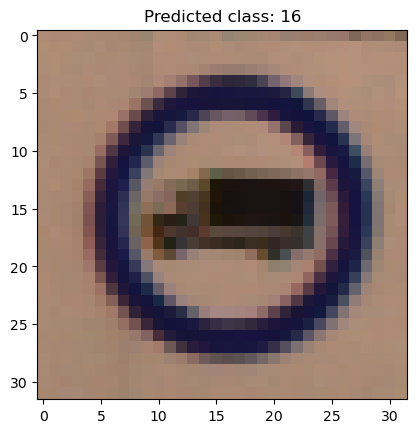

In [23]:
model.eval()
image_path = veri_path+'\\Test\\00000.png'
input_image = Image.open(image_path)

transform = transforms.Compose([
    transforms.Resize((32, 32)), 
    transforms.ToTensor(),
])

input_image = cv2.imread(os.path.join(image_path))
input_image = cv2.resize(input_image,(32,32))
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

input_tensor = transform(input_image)
input_tensor = input_tensor.unsqueeze(0)

with torch.no_grad(): 
    outputs = model(input_tensor)

final_output = outputs['output']
_, predicted_class = torch.max(final_output, 1)
plt.imshow(input_image)
plt.title(f'Predicted class: {predicted_class.item()}')

conv1_output = outputs['image'].int_repr()
print(conv1_output)
num_values = conv1_output.numel()
#kernel = conv1_output.int_repr()
#out_channels = conv1_output.shape[1] 
#image_size = (conv1_output.shape[2], conv1_output.shape[3]) 




In [ ]:
image_path = veri_path+'\\Test\\00003.png'
input_image = Image.open(image_path)

transform = transforms.Compose([
    transforms.Resize((32, 32)), 
    transforms.ToTensor(),
])

input_tensor = transform(input_image)
input_tensor = input_tensor.unsqueeze(0)

with torch.no_grad(): 
    outputs = model(input_tensor)

tensor_in = outputs['image'].int_repr()
tensor_in = tensor_in.squeeze(0)
string_tensor_in_arr = []
string_tensor_in_mat = []
# Prepare the output data
with open('ahuhu.txt', "w") as outfile:
    for row in range(tensor_in.shape[1]):
        string_tensor_in_arr = []
        for col in range(tensor_in.shape[2]):
            # Extract the 3-channel pixel values
            pixel_values = tensor_in[:, row, col]
            # Convert each channel value to hex and concatenate
            hex_pixel = ''.join(f"{round(pixel_values[i].item()):02x}" for i in reversed(range(tensor_in.shape[0])))
            outfile.write(hex_pixel + "\n")
            string_tensor_in_arr.append(hex_pixel)
        string_tensor_in_mat.append(string_tensor_in_arr)


In [ ]:
import os
import glob
from PIL import Image
import torch
from torchvision import transforms

def convert_to_64bit(hex_values, output_file, split_size=16):

    hex_values.reverse()  # Reverse order
    hex_data = "".join(hex_values)  # Concatenate into a single string

    # Split into fixed-size chunks (e.g., 16 characters per line)
    chunks = [hex_data[i:i+split_size] for i in range(0, len(hex_data), split_size)]

    chunks.reverse()
    
    with open(output_file, "w") as f:
        f.write("\n".join(chunks) + "\n")  # Write output with new lines

# Path to your Test directory

test_dir = os.path.join(veri_path+'\\Test\\')

# Prepare your transform once

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Find all PNGs, sort by filename (so 00000.png, 00001.png, …)
png_files = sorted(glob.glob(os.path.join(test_dir, "*.png")))
pixel_array = []
# Open output file once (will overwrite if exists)
#with open("all_images_hex.txt", "w") as outfile:
for png_path in png_files:
    # Optional: write a header for each image
    # outfile.write(f"# {os.path.basename(png_path)}\n")

    # Load & run through model
    input_image = cv2.imread(os.path.join(png_path))
    input_image = cv2.resize(input_image,(32,32))
    input_tensor = transform(input_image).unsqueeze(0)  # add batch dim
    with torch.no_grad():
        outputs = model(input_tensor)

        # Extract your tensor and drop the batch dim
    tensor_in = outputs['image'].int_repr().squeeze(0)

        # Loop rows x cols
    for row in range(tensor_in.shape[1]):
        for col in range(tensor_in.shape[2]):
            # pull out the 3 channels (C, H, W)
            pixel = tensor_in[:, row, col]
            # pack into hex (BGR → RGB reversed)
            hex_pixel = ''.join(f"{int(pixel[i].item()):02x}" for i in reversed(range(pixel.shape[0])))
            pixel_array.append(hex_pixel)
            #outfile.write(hex_pixel + "\n")
convert_to_64bit(pixel_array,"quantize_test_image_bitstream.mem")





In [21]:
with open("all_images_hex.txt", "w") as outfile:
    for png_path in png_files:
        # Optional: write a header for each image
        # outfile.write(f"# {os.path.basename(png_path)}\n")

        # Load & run through model
        img = Image.open(png_path)
        input_tensor = transform(img).unsqueeze(0)  # add batch dim
        with torch.no_grad():
            outputs = model(input_tensor)

        # Extract your tensor and drop the batch dim
        tensor_in = outputs['image'].int_repr().squeeze(0)

        # Loop rows x cols
        for row in range(tensor_in.shape[1]):
            for col in range(tensor_in.shape[2]):
                # pull out the 3 channels (C, H, W)
                pixel = tensor_in[:, row, col]
                # pack into hex (BGR → RGB reversed)
                hex_pixel = ''.join(f"{int(pixel[i].item()):02x}" for i in reversed(range(pixel.shape[0])))
                outfile.write(hex_pixel + "\n")

TESTING IN 1 CONV

In [36]:
#array to file converter
import numpy as np


def save_array_to_file(array, file_path, file_format="txt", fl_t="int_type"):
    """
    Saves a NumPy array or PyTorch tensor to a file with one value per line if the format is 'txt'.

    Args:
        array (np.ndarray or torch.Tensor): Input array or tensor.
        file_path (str): Path to save the file.
        file_format (str): Format of the file ('txt' or 'npy'). Default is 'txt'.
    """
    # Convert PyTorch tensor to NumPy array if necessary
    if isinstance(array, torch.Tensor):
        array = array.cpu().numpy()  # Convert tensor to NumPy array

    # Ensure input is now a NumPy array
    if not isinstance(array, np.ndarray):
        raise ValueError("Input must be a NumPy array or a PyTorch tensor.")

    # Flatten the array to ensure one value per line
    array = array.flatten()

    # Save the array in the specified format
    if file_format == "txt":
        if(fl_t == "float_type"):
            np.savetxt(file_path, array, fmt="%.6f")
        else:
            np.savetxt(file_path, array, fmt="%d")
    elif file_format == "npy":
        np.save(file_path, array)
    else:
        raise ValueError("Unsupported file format. Use 'txt' or 'npy'.")



In [29]:
print(outputs['pool1'].shape)

torch.Size([1, 40, 15, 15])


In [14]:
def split_string_by_two(s):
    return [s[i:i+2] for i in range(0, len(s), 2)]

def hex_difference_acceptable(hex1, hex2):
    return abs(int(hex1, 16) - int(hex2, 16)) <= 1

def compare_files(file1, file2):
    with open(file1, 'r') as f1, open(file2, 'r') as f2:
        lines1 = f1.readlines()
        lines2 = f2.readlines()
    
    if len(lines1) != len(lines2):
       print("Error: Files have different number of lines")
       return
    
    for line_num, (line1, line2) in enumerate(zip(lines1, lines2), start=1):
        parts1 = split_string_by_two(line1.strip())
        parts2 = split_string_by_two(line2.strip())
        
        if len(parts1) != len(parts2):
            print(f"Error in line {line_num}: Mismatched string lengths after splitting")
            continue
        
        for idx, (p1, p2) in enumerate(zip(parts1, parts2)):
            if not hex_difference_acceptable(p1, p2):
                print(f"Error in line {line_num}, segment {idx+1}: {p1} vs {p2}")

In [63]:
hw_path = "conv3_sw_rs.txt"
sw_path = "C:\\Users\\lckd2\\CNN-main\\CNN-main.sim\\sim_1\\behav\\xsim\\conv3_hw_rs.txt"
compare_files(hw_path,sw_path)

Error in line 16, segment 22: 80 vs 7e
Error in line 25, segment 29: 8a vs 88
Error in line 37, segment 34: 8d vs 8b
Error in line 38, segment 34: 8f vs 8d
Error in line 45, segment 34: 8d vs 8b
Error in line 47, segment 29: 87 vs 85
Error in line 47, segment 32: 86 vs 84
Error in line 49, segment 21: 74 vs 76
Error in line 51, segment 32: 86 vs 84
Error in line 63, segment 39: 85 vs 83
Error in line 67, segment 39: 81 vs 7f
Error in line 75, segment 8: 84 vs 82
Error in line 81, segment 34: 81 vs 7f
Error in line 85, segment 34: 7f vs 7d
Error in line 87, segment 34: 7f vs 7d
Error in line 93, segment 21: 7c vs 7e
Error in line 147, segment 35: 81 vs 7f
Error in line 163, segment 21: 81 vs 83
Error in line 163, segment 34: 77 vs 75
Error in line 164, segment 21: 85 vs 87


In [279]:
print(model)

QuantizedTrafficSignModel_1(
  (quant): Quantize(scale=tensor([0.0292]), zero_point=tensor([128]), dtype=torch.quint8)
  (dequant): DeQuantize()
  (conv1): QuantizedConv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), scale=0.04566194862127304, zero_point=128)
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=(1, 1), ceil_mode=False)
  (conv2): QuantizedConv2d(40, 20, kernel_size=(1, 1), stride=(1, 1), scale=0.05472395196557045, zero_point=128)
  (conv3): QuantizedConv2d(20, 48, kernel_size=(3, 3), stride=(1, 1), scale=0.05733923614025116, zero_point=128)
  (conv4): QuantizedConv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), scale=0.15728062391281128, zero_point=128)
  (conv5): QuantizedConv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), scale=0.3021003305912018, zero_point=128)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=(1, 1), ceil_mode=False)
  (conv6): QuantizedConv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), scale=0.22

In [44]:
def split_line_to_9_lines(line):
    line = line.strip()
    part_len = len(line) // 9
    return [line[i:i + part_len] for i in range(0, len(line), part_len)]

def process_file(input_file, output_file):
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        for line_num, line in enumerate(infile, 1):
            if len(line.strip()) % 9 != 0:
                print(f"Warning: Line {line_num} length not divisible by 9. Skipping.")
                continue
            parts = split_line_to_9_lines(line)
            for part in parts:
                outfile.write(part + '\n')

# Usage
input_path = 'C:\\Users\\lckd2\\CNN-main\\CNN-main.sim\\sim_1\\behav\\xsim\\conv8_lb_hw_rs.txt'
output_path = 'conv8_lb.txt'
process_file(input_path, output_path)

In [17]:
# Load the tensor from the .pt file
tensor_in = outputs['image'].int_repr()  # Assuming tensor is saved as a PyTorch tensor
# Squeeze the batch dimension to get a (3, 32, 32) tensor
tensor_in = tensor_in.squeeze(0)
string_tensor_in_arr = []
string_tensor_in_mat = []
# Prepare the output data
with open('ahuhu.txt', "w") as outfile:
    for row in range(tensor_in.shape[1]):
        string_tensor_in_arr = []
        for col in range(tensor_in.shape[2]):
            # Extract the 3-channel pixel values
            pixel_values = tensor_in[:, row, col]
            # Convert each channel value to hex and concatenate
            hex_pixel = ''.join(f"{round(pixel_values[i].item()):02x}" for i in reversed(range(tensor_in.shape[0])))
            outfile.write(hex_pixel + "\n")
            string_tensor_in_arr.append(hex_pixel)
        string_tensor_in_mat.append(string_tensor_in_arr)
print(len(string_tensor_in_mat[0]))
print(f"Tensor converted and saved to ahuhu.txt")

32
Tensor converted and saved to ahuhu.txt


In [18]:
print(outputs['conv9'].int_repr().flatten())

tensor([128, 128, 128, 130, 128, 128, 128, 128, 128, 147, 128, 128, 128, 128,
        132, 128, 128, 128, 147, 128, 128, 128, 128, 128, 128, 128, 128, 130,
        128, 128, 128, 144, 140, 135, 153, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 149, 159, 128, 128, 135, 128, 128, 133, 129, 128, 130,
        128, 128, 128, 128, 131, 128, 139, 128], dtype=torch.uint8)


In [89]:
import math
def process_hex_file(filename):
    pixel_arrays = []  # List to store pixel arrays
    reversed_arrays = []  # List to store reversed pixel arrays
    line_count = 0

    with open(filename, 'r') as file:
        for line in file:
            line = line.strip()  # Remove any trailing newline or spaces
            pixel_array = [int(line[i:i+2], 16) for i in range(0, len(line), 2)]
            pixel_arrays.append(pixel_array)

            # Reverse the pixel array
            reversed_array = pixel_array[::-1]
            reversed_arrays.append(reversed_array)
            line_count += 1  # Increment line count

    return pixel_arrays, reversed_arrays, line_count

# Example usage
#filename = "conv10_sw_rs.txt" # Change this to your actual file
filename = "C:\\Users\\lckd2\\CNN-main\\CNN-main.sim\\sim_1\\behav\\xsim\\fc_hw_rs.txt" # Change this to your actual file
pixels, reversed_indices, line_count = process_hex_file(filename)

#print("Pixel Arrays:", pixels)
#print("Reversed Position Arrays:", reversed_indices)

sw_rs = []
line = 0 
reversed_indices = np.array(reversed_indices)
print(reversed_indices.shape)
size = int(math.sqrt(line_count))
# Reshape the 1D array into a 2D array
sw_rs = reversed_indices.reshape(size,size,43)
#for i in range(64):
#    print(sw_rs[0,0,i])
#    print(sw_rs_a[0,0,(63-i)])  
#    print("DGG") 



(1, 43)


In [81]:
s_weight = model.fc.weight().q_scale()
s_out =  outputs['fc'].q_scale()
s_activate = outputs['conv9'].q_scale()
s_comb = (s_activate * s_weight) / s_out
input_a = model.fc.weight().int_repr()[0]
input_b = outputs['conv9'].int_repr().detach().squeeze()
print(input_a)
print(input_b)
np_a = input_a.numpy()
np_b = input_b.numpy()
print((np.sum(np_a*np_b)))
conv_rs = (np.sum(np_a*np_b))
print(conv_rs*s_comb + bias_test[0] + 128 - 128*s_comb*(np.sum(model.fc.weight().int_repr().detach().numpy())))
print(outputs['fc'].int_repr()[0])


tensor([-14,  33, -50,  -2,  57,  42,  52,   3,  42,  45, -28, -37,  50, -24,
        -91,  40,  63,  -9,  38,  -2,  62, -63,  39, -23,  39,  27, -42, -35,
         57, -19, -25,  41, -34, -18,  17, -15, -30,  31, -64,  29, -65,   2,
         55,  92, -30,  21,  54, -41,  25, -19, -64, -74,   2, -54,  41, -37,
        -29, -53, -17,   1,  25, -10, -36, -25], dtype=torch.int8)
tensor([128, 128, 142, 134, 128, 128, 128, 150, 128, 128, 128, 128, 128, 156,
        128, 128, 128, 128, 128, 128, 128, 153, 149, 128, 128, 128, 128, 128,
        128, 128, 137, 130, 128, 128, 144, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 129, 147, 128,
        128, 128, 128, 155, 154, 128, 129, 136], dtype=torch.uint8)
-7691
tensor(594.0006, grad_fn=<SubBackward0>)
tensor([124, 126,  98, 142, 136, 147, 150, 137, 110, 144, 134, 136, 148, 124,
        129, 136, 174, 110, 125, 130, 128, 115,  98, 140, 115, 115, 115, 134,
        139, 116, 123, 106, 138, 132, 

In [88]:
print(-50*142*s_comb)

-31.27878539309741


In [41]:
s_weight = model.fc.weight().q_scale()
s_out =  outputs['fc'].q_scale()
s_activate = outputs['conv9'].q_scale()
s_comb = (s_activate * s_weight) / s_out

In [ ]:
weights_float = input_a.dequantize().to(torch.float32) 
weights_np = weights_float.detach().numpy()
bias_test = model.fc.bias() / s_out 
print(bias_test)
print(conv_rs)
macc_coeff = conv_rs*s_comb + bias_test + 128 - 128*s_comb*(np.sum(weights_np))
print(macc_coeff.detach().numpy()[0])

tensor([-2.9557e-01,  5.5463e-01,  8.4016e-02, -1.7062e-01,  2.1408e-01,
         1.4210e-01, -8.1082e-02,  1.2986e-01,  2.3609e-01,  2.9384e-01,
        -1.4124e-01,  3.1225e-01,  2.7473e-01,  9.7089e-02, -1.8765e-01,
        -2.5755e-01,  2.7361e-03, -1.5861e-01,  4.2488e-01, -2.6764e-01,
        -1.8805e-02, -1.9140e-01, -5.8698e-02,  1.7885e-02, -4.0144e-02,
         1.2747e-01, -2.3411e-01, -2.6816e-01,  1.9999e-01, -1.5998e-01,
         4.7738e-02,  7.6011e-02,  5.1697e-02,  9.6101e-02, -2.2342e-01,
         1.3657e-01,  1.0910e-01, -3.3402e-01,  2.8662e-01, -1.1794e-01,
         9.1729e-02,  3.0949e-04, -3.4415e-01], grad_fn=<DivBackward0>)
-7691
124.27257


In [ ]:
filename = "conv5_sw_rs.txt" # Change this to your actual file
#filename = "C:\\Users\\lckd2\\CNN-main\\CNN-main.sim\\sim_1\\behav\\xsim\\conv4_hw_rs.txt" # Change this to your actual file
pixels, reversed_indices, line_count = process_hex_file(filename)
sw_rs_a = []
line = 0 
reversed_indices = np.array(reversed_indices)
print(reversed_indices.shape)
size = int(math.sqrt(line_count))
# Reshape the 1D array into a 2D array
sw_rs_a = reversed_indices.reshape(size,size,64)

print(sw_rs_a[0,0,:])

NameError: name 'process_hex_file' is not defined

121


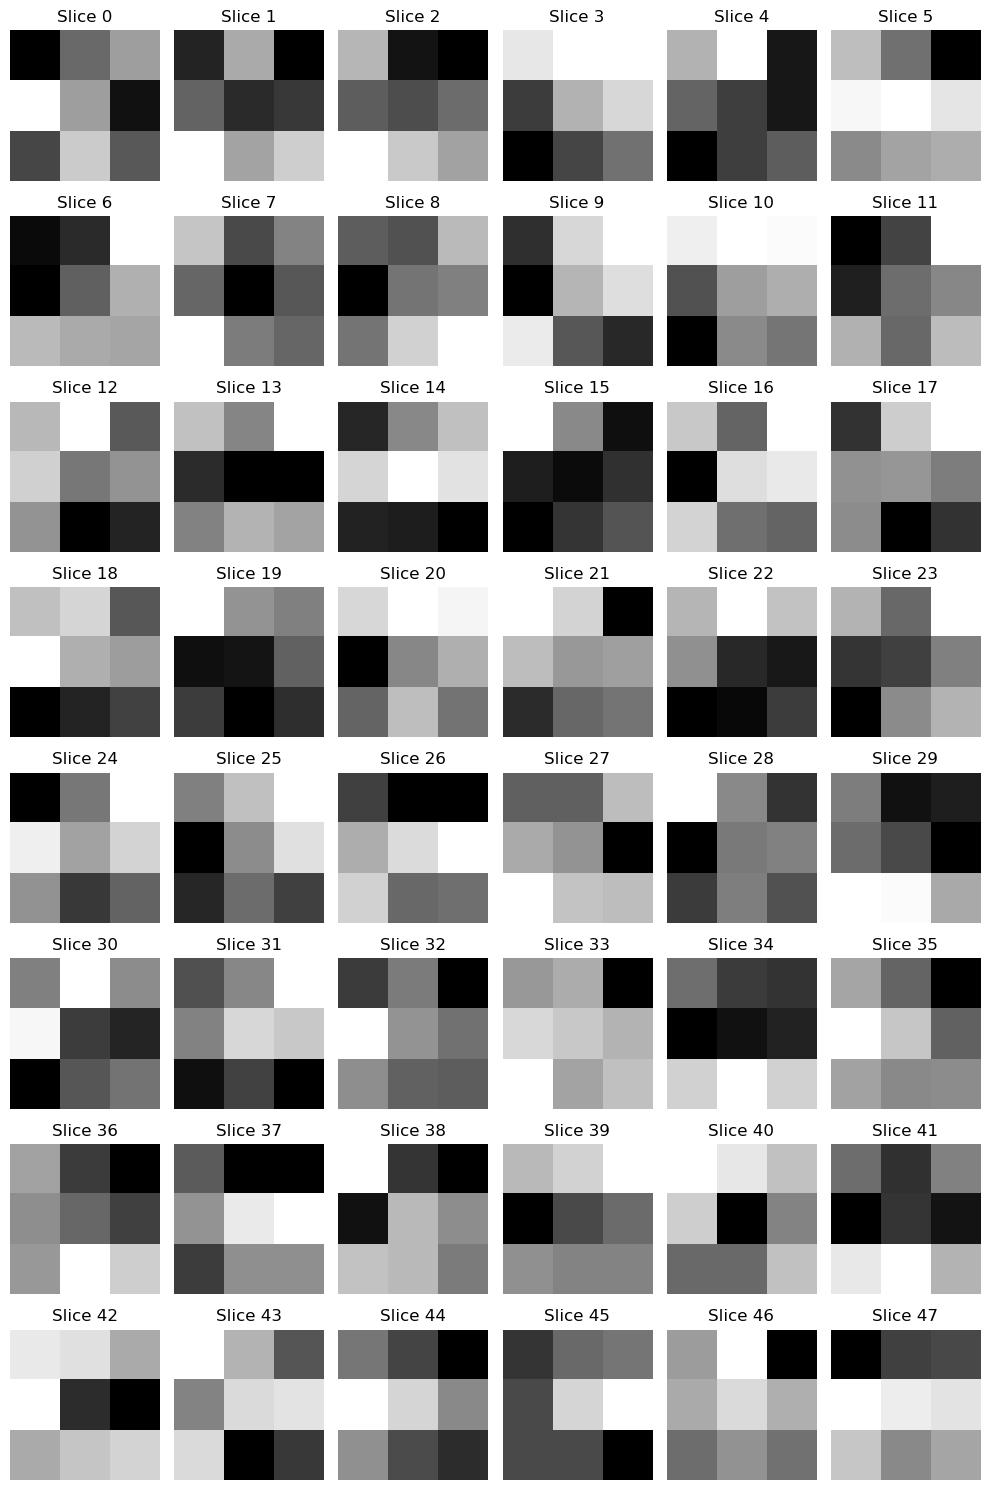

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming reversed_indices is already defined and has 64 slice

# Create a figure with 8 rows × 8 columns (since 8×8=64)
fig, axes = plt.subplots(8, 6, figsize=(10, 15))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Loop through all 64 depth slices
for i in range(48):
    ax = axes[i]  # Select subplot
    ax.imshow(sw_rs[:, :, i], cmap='gray', aspect='auto')  # Display as grayscale
    ax.set_title(f"Slice {i}")  # Title for each slice
    ax.axis("off")  # Hide axis for better visualization

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

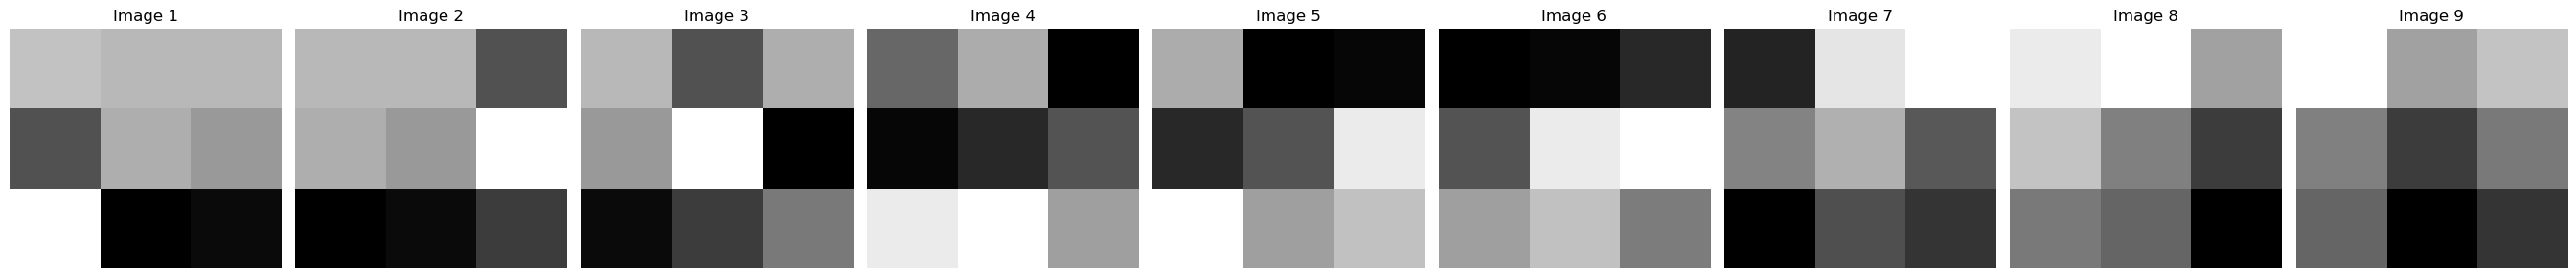

In [66]:

from PIL import Image
import matplotlib.pyplot as plt
import sys

def extract_and_display_images(file_path):
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]

    # Convert first 2 characters of each line to a grayscale value
    pixel_values = [int(f"0x{line[:2]}", 16) for line in lines]

    # Group every 9 pixels into a 3x3 image
    images = [pixel_values[i:i+9][::-1] for i in range(0, len(pixel_values), 9)]

    fig, axs = plt.subplots(1, len(images), figsize=(3 * len(images), 3))

    if len(images) == 1:
        axs = [axs]  # Ensure axs is iterable

    for idx, img_data in enumerate(images):
        img_array = [img_data[i:i+3] for i in range(0, 9, 3)]  # Reshape to 3x3
        img = Image.new("L", (3, 3))
        img.putdata(img_data)
        axs[idx].imshow(img, cmap="gray", aspect='auto')
        axs[idx].axis("off")
        axs[idx].set_title(f"Image {idx+1}")

    plt.tight_layout()
    plt.show()


extract_and_display_images('conv8_lb.txt')

In [220]:
def sum_hex_values(file_path):
    total = 0
    try:
        with open(file_path, 'r') as file:
            for line in file:
                hex_value = line.strip()
                if hex_value:
                    total += int(hex_value, 16)
        print(f"Sum of hex values: {hex(total)} (Decimal: {total})")
        print(f"Sum with bias: {hex(total+3712000)}")
        print(f"Convert value: {hex(int((total+3712000)/65536))}")
    except FileNotFoundError:
        print("Error: File not found.")
    except ValueError:
        print("Error: Invalid hex value in file.")
    return total

# Example usage:
file_path = "C:\\Users\\lckd2\\CNN-main\\CNN-main.sim\\sim_1\\behav\\xsim\\conv4_macc_rs.txt"  # Replace with your actual file path
macc_rs = sum_hex_values(file_path)
print(hex(int(3712000/65536)))
print(hex(int(macc_rs/65536)))
print(hex((int(macc_rs*(81/65536)))))

Sum of hex values: 0x10005dc9db (Decimal: 68725623259)
Sum with bias: 0x1000966ddb
Convert value: 0x100096
0x38
0x10005d
0x5101dac


In [52]:
def process_hex_out_file(input_filename, output_filename, start_line=0, end_line=None):
    with open(input_filename, 'r') as file:
        hex_values = [line.strip() for line in file if line.strip()]
    
    # Apply line range filtering
    hex_values = hex_values[start_line:end_line] if end_line is not None else hex_values[start_line:]
    
    # Step 1: Extract 8 LSB bits (last two characters of each hex value)
    lsb_values = [value[-2:] for value in hex_values]
    
    # Step 2: Arrange in a 48 (length) x 24 (width) 2D array (column-wise filling)
    length, width = 48, 24*3*3
    array_2d = [[''] * width for _ in range(length)]
    
    for i, val in enumerate(lsb_values):
        row = i % length  # Iterate over length first
        col = i // length # Then move to width
        if col < width:
            array_2d[row][col] = val
    
    # Step 3: Reverse each row before concatenation
    concatenated_rows = [''.join(row[::-1]) for row in array_2d]
    
    # Step 4: Write output to a file
    with open(output_filename, 'w') as output_file:
        for row in concatenated_rows:
            output_file.write(row + '\n')
    
    print(f"Processing complete. Output written to {output_filename}")

# Example usage
process_hex_out_file("tsr_fpga_weights_19_1_latest.txt", "cv8_debug.txt", start_line=23192, end_line=23192 + 48*24*3*3)

Processing complete. Output written to cv8_debug.txt


In [58]:
# Prepare a list to store the differences for each c_out
differences = []
diff_arr = []
sw_val_arr = []
tensor_in = outputs['conv8']
tensor_weight = model.conv9.weight()
tensor_bias   = model.conv9.bias()
tensor_out    = outputs['conv9']
rtl_sim_arr   = []
have_relu = 0
for i in range(tensor_out.shape[2]):
    for j in range(tensor_out.shape[3]):
        differences = []
        sw_sims = []
        rtl_sims = []
# Loop over c_out from 0 to 39
        for c_out in range(tensor_out.shape[1]):
            # Extract weights, bias, and input window for the current c_out
            test_weight = tensor_weight[c_out].int_repr()
            test_bias = tensor_bias[c_out]
            test_window = tensor_in[:,:, i:i+tensor_weight.shape[2], j:j+tensor_weight.shape[3]].int_repr()
            #test_window = tensor_in.int_repr() - 128
            # Dequantize and convert to NumPy
            weights_float = test_weight.dequantize().to(torch.float32)  # Dequantize and convert to float32
            bias_float = test_bias.to(torch.float32)                    # Convert bias to float32
            image_float = test_window.dequantize().to(torch.float32)    # Convert image to float32 if needed
            
            # Convert to NumPy arrays
            weights_np = weights_float.detach().numpy()
            bias_np = bias_float.detach().numpy()
            image_np = image_float.detach().numpy()
            # Perform the convolution
            conv_rs = np.sum(weights_np * image_np) 
            #FIXME:
            # Scale and bias calculations
            s_weight = tensor_weight.q_scale()
            s_out = tensor_out.q_scale()
            s_activate = tensor_in.q_scale()
            s_comb = (s_activate * s_weight) / s_out
            #print(weights_np[0][0][0]*image_np[0][0][0])
            bias_test = bias_np / s_out 

            macc_coeff = conv_rs*s_comb + bias_test + 128 - 128*s_comb*(np.sum(weights_np))
            #print(bias_test + 128 - 128*s_comb*(np.sum(weights_np)))
            # Calculate ReLU and RTL simulation
            if(macc_coeff < 0):
                print("NO ROI CAC CHAU OI")
            relu = max(macc_coeff, 128)
            
            if have_relu:
                rtl_sim = round(relu)
            else:
                rtl_sim = round(macc_coeff)
            rtl_sims.append(f"{rtl_sim:02x}") 
            # Software simulation result
            test_output = tensor_out[0][c_out][i][j].int_repr().item()
            #test_output = tensor_out[0][c_out].int_repr().item()
            sw_sim = int(test_output)
            if(j == 0 and i == 0 and c_out == 0):
            #if(c_out == 8 and  j == 0 and i == 0): #36 3 0
                print(bias_test)
                print(conv_rs)
                print(s_comb)
                print(bias_test)
                print(macc_coeff)
                #print(weights_np[:,0,0])
                #print(image_np[0,:,0,0])
            #    for x in range(48):
            #        if(x == 20):
            #            print("AAAA")
            #            print(round(weights_np[x,0,0]))
            #        print(round(weights_np[x,0,0]*image_np[0,x,0,0]))
            #    print(f"SUM = {np.sum(weights_np*image_np)}")
                #print(bias_test + 128 - 128*s_comb*(np.sum(weights_np)))
                #print(bias_test + 128 - 128*s_comb*(np.sum(weights_np)))
                #print(conv_rs*s_comb)
                #print(hex(rtl_sim))
                #print(hex(sw_sim))
            #print(bias_test + 128 - 128*s_comb*(np.sum(weights_np)))
            # Calculate the difference and store it
            difference = abs(sw_sim - rtl_sim)
            differences.append(difference)
            sw_sims.append(sw_sim)
            #error_percentage = (differences / sw_sim ) * 100
            # Optionally print the results for debugging
           # print(f"c_out: {c_out}, SW Sim: {sw_sim}, RTL Sim: {rtl_sim}, Difference: {difference}") 
        rtl_sim_arr.append("".join(reversed(rtl_sims)))  
        # After the loop, you can analyze or save the differences as needed
        diff_arr.append(sum(differences))
        sw_val_arr.append(sum(sw_sims))


-0.07689473811655813
-42824.0
0.0016741524901089401
-0.07689473811655813
106.5877059279351


In [ ]:
kernel_list = []
bias_list = []
macc_coeff_list = []
layer_scale_list = []

# Chuẩn bị kernel và bias
print(weights_np.shape)
print(bias_np.shape)
bias_list.append(bias_np / s_out)
for fil in range(weights_np.shape[0]):
    for row in range(weights_np.shape[2]):  # kernel_height
        for cha in range(weights_np.shape[1]):  # in_channels
            kernel_list.append(np.clip(weights_np[fil, cha, row], -128, 128).tolist().astype(np.int16).tolist()) #FIXME

# Chuẩn bị hệ số MACC (Multiply-Accumulate Coefficient)
macc_coeff_list.append(s_activate*s_weight/s_out)

# Chuẩn bị scale của layer
layer_scale_list.append(s_out)

# Kết quả
print(
    f'Num kernel      : {len(kernel_list)}\n'
    f'Num bias        : {len(bias_list)}\n'
    f'Num macc_coeff  : {len(macc_coeff_list)}\n'
    f'Num layer_scale : {len(layer_scale_list)}\n'
    f'Total weights   : {len(kernel_list) + len(bias_list) + len(macc_coeff_list) + len(layer_scale_list)}'
)
print(kernel_list)
# Write to file
byte_array = bytearray()
bias_qformat = {'m': 8, 'n': 8, 'signed': 1}
scale_qformat = {'m': 2, 'n': 16, 'signed': 0}

# Hàm chuyển đổi số thực sang fixed-point
def to_fixed_point(val, qformat):
    m, n, signed = qformat['m'], qformat['n'], qformat['signed']
    scale = 2 ** n
    max_val = (2 ** (m + n - 1) - 1) if signed else (2 ** (m + n) - 1)
    min_val = -(2 ** (m + n - 1)) if signed else 0
    
    val_fixed = int(round(val * scale))
    val_clipped = max(min(val_fixed, max_val), min_val)
    return val_clipped

# Ghi kernel_list
for val in kernel_list:
    byte_array.extend((int(val) & 0xffff).to_bytes(length=2, byteorder='little', signed=True))

# Ghi bias_list
for val in bias_list:
    fixed_val = to_fixed_point(val, bias_qformat)
    byte_array.extend(fixed_val.to_bytes(length=2, byteorder='little', signed=True))

# Ghi macc_coeff_list và layer_scale_list
for val in macc_coeff_list + layer_scale_list:
    fixed_val = to_fixed_point(val, scale_qformat)
    byte_array.extend(fixed_val.to_bytes(length=2, byteorder='little', signed=False))

# Lưu byte array vào file
with open("test_macc_coeff.txt", "wb") as f:
    f.write(byte_array)

(3, 3, 3)
()


AttributeError: 'float' object has no attribute 'astype'

In [188]:
byte_array = bytearray()
bias_qformat = {'m': 8, 'n': 8, 'signed': 1}
scale_qformat = {'m': 2, 'n': 16, 'signed': 0}

for val in :
    byte_array.extend((val.item() & 0xffff).to_bytes(length=2, byteorder='little'))

for val in bias_list:
    byte_array.extend(int(f'{FixedPoint(val, **bias_qformat):04x}', 16).to_bytes(length=2, byteorder='little'))

for val in macc_coeff_list + layer_scale_list:
    byte_array.extend(int(f'{FixedPoint(val, **scale_qformat):04x}', 16).to_bytes(length=2, byteorder='little'))


IndentationError: unexpected indent (1356927271.py, line 2)

In [15]:
checkpoint_path = 'traffic_sign_model_quantized_final.pth'
model = QuantizedTrafficSignModel_1()
model = quantize_model(model, test_loader)
model.load_state_dict(torch.load(checkpoint_path), strict=False)

NameError: name 'quantize_model' is not defined

chay

In [41]:
def test_quantized_model(model, test_loader, device='cpu'):
    model.eval()
    model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            outputs = outputs['output']
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == torch.max(labels, 1)[1]).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the quantized model on the test set: {accuracy:.1f}%')

    return accuracy

test_quantized_model(quantized_model_final, test_loader, device='cpu')

Accuracy of the quantized model on the test set: 95.6%


95.55819477434679

In [42]:
checkpoint_path = 'traffic_sign_model_quantized_final.pth'
model = QuantizedTrafficSignModel()
model = quantize_model(model, test_loader)
model.load_state_dict(torch.load(checkpoint_path), strict=False)

write_weights(model)


C:\Users\lckd2\AppData\Local\Temp\ipykernel_237352\1264006323.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path), strict=F

NameError: name 'write_weights' is not defined

In [44]:
with open("quantization_info.txt", "w") as f:
    for name, module in model.named_modules():
        if isinstance(module, (nn.quantized.Conv2d, nn.quantized.Linear)):
            f.write(f"Layer: {name}\n")
            f.write(f"  Scale: {module.scale}\n")
            f.write(f"  Zero Point: {module.zero_point}\n\n")

print("Quantization info saved to quantization_info.txt")

Quantization info saved to quantization_info.txt


In [87]:
#SCRIPT TO GENERATE RTL CODE
import torch.nn.functional as F
import torch.nn as nn
import argparse

def rtl_gen(model, rtl_path, fifo_factor=1):

    conv1_layer_1 = model.conv1
    pool1_layer_2 = model.pool1
    conv2_layer_3 = model.conv2
    conv3_layer_4 = model.conv3
    conv4_layer_5 = model.conv4
    conv5_layer_6 = model.conv5
    pool2_layer_7 = model.pool2
    conv6_layer_8 = model.conv6
    conv7_layer_9 = model.conv7
    conv8_layer_10 = model.conv8
    conv9_layer_11 = model.conv9
    fc1_layer_12 = model.fc

    with open(rtl_path, 'w') as f:
        f.write(
            '`timescale 1ns / 1ps\n'
            '\n'
            'module tsr_model (\n'
            '    output [8*43-1:0] o_data,\n'
            '    output            o_valid,\n'
            '    output            fifo_rd_en,\n'
            '    input  [8*3-1:0]  i_data,\n'
            '    input             i_valid,\n'
            '    input             almost_full,\n'
            '    input  [15:0]     weight_wr_data,\n'
            '    input  [31:0]     weight_wr_addr,\n'
            '    input             weight_wr_en,\n'
            '    input             clk,\n'
            '    input             rst_n\n'
            ');\n\n'
        )

        in_size = (32,32)

        # Encoder stages
        for i, layer in enumerate([conv1_layer_1,pool1_layer_2,conv2_layer_3,conv3_layer_4,conv4_layer_5,conv5_layer_6,pool2_layer_7,conv6_layer_8,conv7_layer_9,conv8_layer_10,conv9_layer_11,fc1_layer_12]):
            if(isinstance(layer,nn.Linear)):
                in_channel = layer.in_features
                out_channel = layer.out_features
            else:
                if(isinstance(layer,nn.MaxPool2d)):
                    in_channel = pre_in_channel
                    out_channel = pre_in_channel
                else:
                    in_channel = layer.in_channels
                    out_channel = layer.out_channels
                pre_in_channel = in_channel
                kernel_size = layer.kernel_size
                padding = layer.padding
                dilation = layer.dilation
                stride = layer.stride
            layer_num = i 
            if layer_num == 0:
                i_data = 'i_data'
                i_valid = 'i_valid'
                conv_fifo_rd_en = 'fifo_rd_en'
            else:
                i_data = f'fifo_rd_data_{layer_num-1}'
                i_valid = f'~fifo_empty_{layer_num-1}'
                conv_fifo_rd_en = f'fifo_rd_en_{layer_num-1}'

            compute_factor = 'single'
            if isinstance(layer, nn.Conv2d):

                f.write(
                    f'    // Conv {layer_num}\n'
                    f'    wire [8*{out_channel}-1:0] o_data_{layer_num};\n'
                    f'    wire o_valid_{layer_num};\n'
                    f'    wire fifo_almost_full_{layer_num};\n'
                    f'\n'
                    f'    conv #(\n'
                    f'        .UNROLL_MODE           ("incha"),\n'
                    f'        .IN_WIDTH              ({int(in_size[1])}),\n'
                    f'        .IN_HEIGHT             ({int(in_size[0])}),\n'
                    f'        .OUTPUT_MODE           ("relu"),\n'
                    f'        .COMPUTE_FACTOR        ("{compute_factor}"),\n'
                    f'        .KERNEL_0              ({kernel_size[0]}),\n'
                    f'        .KERNEL_1              ({kernel_size[1]}),\n'
                    f'        .PADDING_0             ({padding[0]}),\n'
                    f'        .PADDING_1             ({padding[1]}),\n'
                    f'        .DILATION_0            ({dilation[0]}),\n'
                    f'        .DILATION_1            ({dilation[1]}),\n'
                    f'        .STRIDE_0              ({stride[0]}),\n'
                    f'        .STRIDE_1              ({stride[1]}),\n'
                    f'        .IN_CHANNEL            ({in_channel}),\n'
                    f'        .OUT_CHANNEL           ({out_channel}),\n'
                    f'        .KERNEL_BASE_ADDR      (),\n'
                    f'        .BIAS_BASE_ADDR        (),\n'
                    f'        .MACC_COEFF_BASE_ADDR  (),\n'
                    f'        .LAYER_SCALE_BASE_ADDR ()\n'
                    f'    ) u_enc_{layer_num} (\n'
                    f'        .o_data                (o_data_{layer_num}),\n'
                    f'        .o_valid               (o_valid_{layer_num}),\n'
                    f'        .fifo_rd_en            ({conv_fifo_rd_en}),\n'
                    f'        .i_data                ({i_data}),\n'
                    f'        .i_valid               ({i_valid}),\n'
                    f'        .fifo_almost_full      (1\'b0),\n'
                    f'        .weight_wr_data        (weight_wr_data),\n'
                    f'        .weight_wr_addr        (weight_wr_addr),\n'
                    f'        .weight_wr_en          (weight_wr_en),\n'
                    f'        .clk                   (clk),\n'
                    f'        .rst_n                 (rst_n)\n'
                    f'    );\n\n'
                )
                
            elif isinstance(layer, nn.MaxPool2d):
                f.write(
                    f'    // MaxPool {layer_num}\n'
                    f'    wire [8*{out_channel}-1:0] o_data_{layer_num};\n'
                    f'    wire o_valid_{layer_num};\n'
                    f'    wire fifo_almost_full_{layer_num};\n'
                    f'\n'
                    f'    max_pooling #(\n'
                    f'        .DATA_WIDTH               (8),\n'
                    f'        .IN_WIDTH                 ({int(in_size[1])}),\n'
                    f'        .IN_HEIGHT                ({int(in_size[0])}),\n'
                    f'        .IN_CHANNEL               ({in_channel}),\n'       
                    f'        .PADDING_0                ({padding[0]}),\n'
                    f'        .PADDING_1                ({padding[1]}),\n'
                    f'        .DILATION_0               ({dilation[0]}),\n'
                    f'        .DILATION_1               ({dilation[1]}),\n'
                    f'        .STRIDE_0                 ({stride[0]}),\n'
                    f'        .STRIDE_1                 ({stride[1]})\n'
                    f'    ) u_max_{layer_num} (\n'
                    f'        .o_data                   (o_data_{layer_num}),\n'
                    f'        .o_valid                  (o_valid_{layer_num}),\n'
                    f'        .fifo_rd_en               ({conv_fifo_rd_en}),\n'
                    f'        .i_data                   ({i_data}),\n'
                    f'        .i_valid                  ({i_valid}),\n'
                    f'        .fifo_almost_full         (1\'b0),\n'
                    f'        .clk                      (clk),\n'
                    f'        .rst_n                    (rst_n)\n'
                    f'    );\n\n'
                )

            elif isinstance(layer,nn.Linear):
                f.write(
                    f'    // Fully connected {layer_num}\n'
                    f'    wire [8*{out_channel}-1:0] o_data_{layer_num};\n'
                    f'    wire o_valid_{layer_num};\n'
                    f'    wire fifo_almost_full_{layer_num};\n'
                    f'\n'
                    f'    fc #(\n'
                    f'        .IN_CHANNEL               ({in_channel}),\n'
                    f'        .OUT_CHANNEL              ({out_channel}),\n'
                    f'        .KERNEL_0                 (1)'
                    f'        .KERNEL_1                 (1)'
                    f'        .KERNEL_BASE_ADDR         (),\n'
                    f'        .BIAS_BASE_ADDR           (),\n'
                    f'        .MACC_COEFF_BASE_ADD      (),\n'
                    f'        .LAYER_SCALE_BASE_ADD     ()\n'
                    f'    ) u_fc_{layer_num} (\n'
                    f'        .o_data                (o_data_{layer_num}),\n'
                    f'        .o_valid               (o_valid_{layer_num}),\n'
                    f'        .fifo_rd_en            ({conv_fifo_rd_en}),\n'
                    f'        .i_data                ({i_data}),\n'
                    f'        .i_valid               ({i_valid}),\n'
                    f'        .fifo_almost_full      (1\'b0),\n'
                    f'        .weight_wr_data        (weight_wr_data),\n'
                    f'        .weight_wr_addr        (weight_wr_addr),\n'
                    f'        .weight_wr_en          (weight_wr_en),\n'
                    f'        .clk                   (clk),\n'
                    f'        .rst_n                 (rst_n)\n'
                    f'    );\n\n'
                )
                

            in_size = tuple((in_size[_i] + 2 * padding[_i] - dilation[_i] * (kernel_size[_i] - 1) - 1) / stride[_i] + 1 for _i in range(2))
            buffer_factor = fifo_factor * 2 if i == 0 else fifo_factor
            buffer_depth = max(int(in_size[1]) * buffer_factor, 2)
            f.write(
                f'    wire [8*{out_channel}-1:0] fifo_rd_data_{layer_num};\n'
                f'    wire fifo_empty_{layer_num};\n'
                f'    wire fifo_rd_en_{layer_num};\n'
                f'\n'
                f'    fifo_single_read #(\n'
                f'        .DATA_WIDTH        (8 * {out_channel}),\n'
                f'        .DEPTH             ({buffer_depth}),\n'
                f'        .ALMOST_FULL_THRES (10)\n'
                f'    ) u_fifo_{layer_num} (\n'
                f'        .rd_data           (fifo_rd_data_{layer_num}),\n'
                f'        .empty             (fifo_empty_{layer_num}),\n'
                f'        .full              (),\n'
                f'        .almost_full       (fifo_almost_full_{layer_num}),\n'
                f'        .wr_data           (o_data_{layer_num}),\n'
                f'        .wr_en             (o_valid_{layer_num}),\n'
                f'        .rd_en             (fifo_rd_en_{layer_num}),\n'
                f'        .rst_n             (rst_n),\n'
                f'        .clk               (clk)\n'
                f'    );\n\n'
                )

        f.write('endmodule\n')

def weight_addr_map(rtl_path):
    with open(rtl_path, 'r') as f:
        lines = f.readlines()

    total_weights = 0
    kernel_0 = 0
    kernel_1 = 0
    in_channel = 0
    out_channel = 0
    output_mode = ''

    # Kernel
    for i, line in enumerate(lines):
        if 'KERNEL_0' in line:
            kernel_0 = int(line.split('(')[1].split(')')[0])
        if 'KERNEL_1' in line:
            kernel_1 = int(line.split('(')[1].split(')')[0])
        if 'IN_CHANNEL' in line:
            in_channel = int(line.split('(')[1].split(')')[0])
        if 'OUT_CHANNEL' in line:
            out_channel = int(line.split('(')[1].split(')')[0])
        if 'KERNEL_BASE_ADDR' in line:
            num_weights = kernel_0 * kernel_1 * in_channel * out_channel
            lines[i] = line.split('(')[0] + f'({total_weights}),  // Num kernel: {num_weights}\n'
            total_weights += num_weights

    # Bias
    for i, line in enumerate(lines):
        if 'OUT_CHANNEL' in line:
            out_channel = int(line.split('(')[1].split(')')[0])
        if 'BIAS_BASE_ADDR' in line:
            lines[i] = line.split('(')[0] + f'({total_weights}),  // Num bias: {out_channel}\n'
            total_weights += out_channel

    # MACC co-efficient
    for i, line in enumerate(lines):
        if 'MACC_COEFF_BASE_ADDR' in line:
            lines[i] = line.split('(')[0] + f'({total_weights}),  // Num macc_coeff: 1\n'
            total_weights += 1

    # Layer scale
    for i, line in enumerate(lines):
        if 'OUTPUT_MODE' in line:
            output_mode = line.split('"')[1]
        if 'LAYER_SCALE_BASE_ADDR' in line and output_mode in ['dequant', 'sigmoid']:
            lines[i] = line.split('(')[0] + f'({total_weights})   // Num layer_scale: 1\n'
            total_weights += 1

    print(f'Total weights: {total_weights:,}')
    with open(rtl_path, 'w') as f:
        for line in lines:
            f.write(line)


def main():


    # Initialize model
    #model = QuantLaneNetQuantized().to('cpu')
    #model = convert_quantized_model(model)
    model = QuantizedTrafficSignModel_1()
    # Write RTL file
    rtl_gen(model=model, rtl_path='./model.v', fifo_factor=1)
    weight_addr_map(rtl_path='./model.v')
#add more number in QuantizedTrafficSignModel_1()
if __name__ == '__main__':
    main()


Total weights: 56,680


In [ ]:
model.eval()

# Hook function to capture input and output
def hook_fn(module, input, output):
    print(f"Layer: {module}")
    print(f"Input: {input}")
    print(f"Output: {output}")

# Register the hook on the fc layer
model.fc.register_forward_hook(hook_fn)

# Pass a sample input through the model
sample_input = torch.randn(1, 3, 32, 32)  # Adjust dimensions based on your model
output = model(sample_input)

In [ ]:

def hook_fn(module, input, output):
    print(f"Layer: {module}")
    print(f"Input: {input}")
    print(f"Output: {output}")
# Register the hook on the fc layer
model.conv1.register_forward_hook(hook_fn)

# Pass a sample input through the model
sample_input = torch.randn(1, 3, 32, 32)  # Adjust dimensions based on your model
output = model(sample_input)

In [ ]:
model.eval()
def hook_fn(module, input, output):
    print(f"Layer: {module}")
    print(f"Input: {input}")
    print(f"Output: {output}")
# Register the hook on the fc layer
model.fc.register_forward_hook(hook_fn)

# Pass a sample input through the model
sample_input = torch.randn(1, 3, 32, 32)  # Adjust dimensions based on your model
output = model(sample_input)